In [22]:
'''
Author: Aditya Jain
Date  : 16th November, 2020
About : This code contains a RNN model with CTC loss function for primitive segmentation in a video
'''
# import comet_ml at the top of your file
from comet_ml import Experiment
# Create an experiment with your api key:
experiment = Experiment(
    api_key="epeaAhyRcHSkn92H4kusmbX8k",
    project_name="ctc-lfd",
    workspace="adityajain07",
    log_code="True"
)
experiment.set_code()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/adityajain07/ctc-lfd/6bda73201faf4b69a32a5597390bd09e
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (57 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     os packages              : 1
COMET INFO: ---------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/adityajain07/ctc-lfd/2fe3a1dda66f40c99f73ea06662eeec9



In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from CTCModel import CTCModel as CTCModel
from keras.layers import LSTM, TimeDistributed, Dense, Activation, Input
from keras.optimizers import Adam
from numpy import zeros
import h5py

#### Loading IAM Dataset

In [5]:
dataset_path = "/home/aditya/Dropbox/LearningfromDemons/ctc_data/iam_lines.h5"

with h5py.File(dataset_path, "r") as f:
    x_train = f['x_train'][:]
    y_train = f['y_train'][:]
    x_test  = f['x_test'][:]
    y_test  = f['y_test'][:]
    
    
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(7101, 28, 952)
(7101, 97)
(1861, 28, 952)
(1861, 97)


#### Defining model architecture

In [25]:
h_features = 10
nb_labels = 10

input_layer = Input((None, h_features))
lstm0 = LSTM(128, return_sequences=True)(input_layer)
lstm1 = LSTM(128, return_sequences=True)(lstm0)
dense = TimeDistributed(Dense(nb_labels))(lstm1)
output_layer = Activation("sigmoid")(dense)

model = CTCModel([input_layer], [output_layer])
model.compile(optimizer=Adam(lr=1e-4))
model.summary()

# model.save_model('./')

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, None, 128)    71168       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, None, 128)    131584      lstm_9[0][0]                     
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, None, 10)     1290        lstm_10[0][0]                    
______________________________________________________________________________________

## Testing

In [6]:
import os
from six.moves.urllib.request import urlretrieve
from tensorflow.python.keras.utils.generic_utils import Progbar
import pickle
import matplotlib.pyplot as plt

def download_data():
    origin = 'https://www.dropbox.com/s/or7s6zo038cc01v/seqDigits.pkl?dl=1'    
    if not os.path.exists(fpath):
        print("Downloading data")
        class ProgressTracker(object):
              progbar = None

        def dl_progress(count, block_size, total_size):
            if ProgressTracker.progbar is None:
                if total_size == -1:
                    total_size = None
                ProgressTracker.progbar = Progbar(total_size)
            else:
                ProgressTracker.progbar.update(count * block_size)

        urlretrieve(origin, fpath, dl_progress)

fpath = './seqDigits.pkl'
download_data()

# load data from a pickle file
(x_train, y_train), (x_test, y_test) = pickle.load(open(fpath, 'rb'))

101933056/227887628 [============>.................] - ETA: 19s

KeyboardInterrupt: 

In [27]:
(x_train, y_train), (x_test, y_test) = pickle.load(open(fpath, 'rb'))
x_train = x_train[:1000]
y_train = y_train[:1000]

In [3]:
from keras.preprocessing import sequence
import numpy as np

nb_labels = 10 # number of labels (10, this is digits)
batch_size = 32 # size of the batch that are considered
padding_value = 255 # value for padding input observations
nb_epochs = 10 # number of training epochs
nb_train = len(x_train)
nb_test = len(x_test)
nb_features = len(x_train[0][0])

print(nb_train, nb_test, nb_features)


# create list of input lengths
x_train_len = np.asarray([len(x_train[i]) for i in range(nb_train)])
x_test_len = np.asarray([len(x_test[i]) for i in range(nb_test)])
y_train_len = np.asarray([len(y_train[i]) for i in range(nb_train)])
y_test_len = np.asarray([len(y_test[i]) for i in range(nb_test)])

# pad inputs
x_train_pad = sequence.pad_sequences(x_train, value=float(padding_value), dtype='float32',
                                         padding="post", truncating='post')
x_test_pad = sequence.pad_sequences(x_test, value=float(padding_value), dtype='float32',
                                        padding="post", truncating='post')
y_train_pad = sequence.pad_sequences(y_train, value=float(nb_labels),
                                         dtype='float32', padding="post")
y_test_pad = sequence.pad_sequences(y_test, value=float(nb_labels),
                                        dtype='float32', padding="post")

print(np.shape(x_train_pad), np.shape(y_train_pad))

7101 1861 952
(7101, 28, 952) (7101, 97)


In [29]:
from keras.layers import TimeDistributed, Activation, Dense, Input, Bidirectional, LSTM, Masking, GaussianNoise

def create_network(nb_features, nb_labels, padding_value):

    # Define the network architecture
    input_data = Input(name='input', shape=(None, nb_features)) # nb_features = image height

    masking = Masking(mask_value=padding_value)(input_data)
    noise = GaussianNoise(0.01)(masking)
    blstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1))(noise)
    blstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1))(blstm)
    blstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1))(blstm)

    dense = TimeDistributed(Dense(nb_labels + 1, name="dense"))(blstm)
    outrnn = Activation('softmax', name='softmax')(dense)

    network = CTCModel([input_data], [outrnn])
    network.compile(Adam(lr=0.0001))

    return network


print("Network parameters: ", nb_features, nb_labels, padding_value)

# define a recurrent network using CTCModel
network = create_network(nb_features, nb_labels, padding_value)

Network parameters:  28 10 255


In [30]:
print(network.summary())

# CTC training
network.fit(x=[x_train_pad, y_train_pad, x_train_len, y_train_len], y=np.zeros(nb_train), \
                batch_size=batch_size, epochs=nb_epochs)

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 28)]   0                                            
__________________________________________________________________________________________________
masking_2 (Masking)             (None, None, 28)     0           input[0][0]                      
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, None, 28)     0           masking_2[0][0]                  
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, None, 256)    160768      gaussian_noise_2[0][0]           
______________________________________________________________________________________

In [20]:
# Evaluation: loss, label error rate and sequence error rate are requested
eval = network.evaluate(x=[x_test_pad, y_test_pad, x_test_len, y_test_len],\
                            batch_size=batch_size, metrics=['loss', 'ler', 'ser'])


# predict label sequences
pred = network.predict([x_test_pad, x_test_len], batch_size=batch_size, max_value=padding_value)
for i in range(10):  # print the 10 first predictions
    print("Prediction :", [j for j in pred[i] if j!=-1], " -- Label : ", y_test[i]) # 

32/32 [==============================] - 9s 267ms/step
Prediction : []  -- Label :  [3. 3. 1. 4.]
Prediction : []  -- Label :  [1. 1.]
Prediction : []  -- Label :  [0. 7. 2.]
Prediction : []  -- Label :  [6. 4.]
Prediction : []  -- Label :  [5. 8.]
Prediction : []  -- Label :  [0. 6. 9.]
Prediction : []  -- Label :  [6. 8. 6. 6.]
Prediction : []  -- Label :  [4. 1.]
Prediction : []  -- Label :  [8. 4.]
Prediction : []  -- Label :  [2. 3. 3. 1.]


(1000, 112, 28)


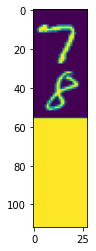

In [58]:
print(x_train_pad.shape)
plt.imshow(x_train_pad[90])